# Stereo Matching

[Github Repository](https://github.com/XiongWenye/Stereo-Matching)

To reproduce the results, make sure that you have already done the calibration and rectification of the stereo images. The rectified images should be stored in the folders rectified_images_output
---

In [1]:
import os, sys, math, shutil, zipfile, io
import numpy as np
import cv2
import matplotlib.pyplot as plt
from PIL import Image

print("Environment ready.")

Environment ready.


In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

PROJECT_DIR = "/content/drive/MyDrive/es-143-assignments-group/Final"
os.makedirs(PROJECT_DIR, exist_ok=True)
os.chdir(PROJECT_DIR)
print("Working directory:", os.getcwd())

Mounted at /content/drive
Working directory: /content/drive/MyDrive/es-143-assignments-group/Final


##WTA + SAD

Loaded rectified pair: shape=(1597, 1240)
Resized to: (1277, 992)
Using disparity range request: [0, 1024]
[WTA+SAD] disparity range = [0, 1024], numD = 1025


WTA+SAD: 100%|████████████████████████████| 1025/1025 [00:16<00:00, 61.23disp/s]


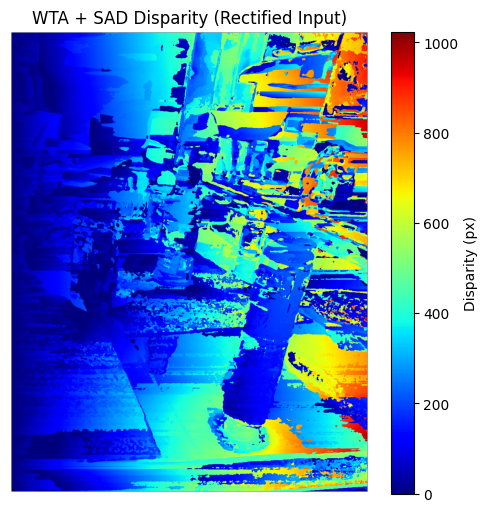

Saved disparity: /content/drive/MyDrive/es-143-assignments-group/Final/0.8_12121108_outputs/disp_wta_sad_rectified.png


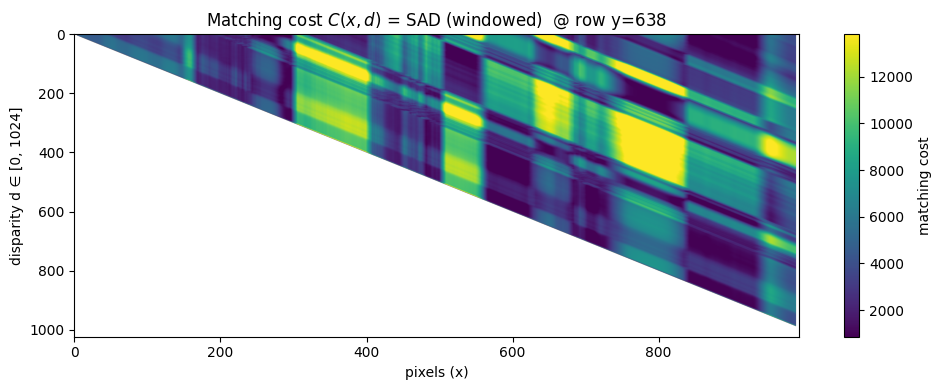

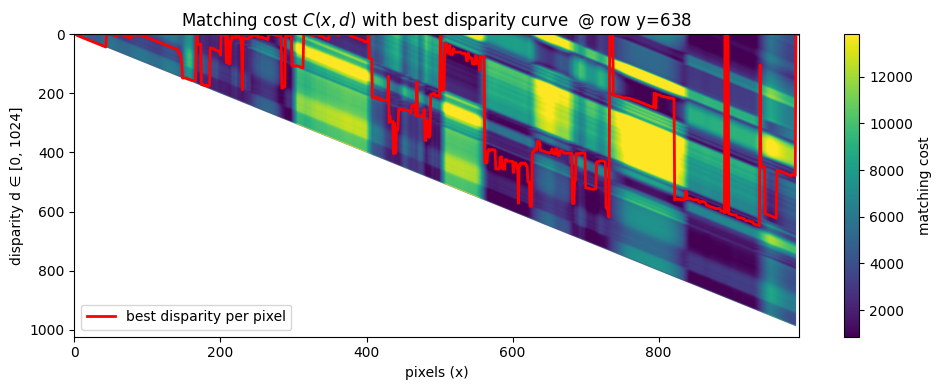

Saved cost volume figure: /content/drive/MyDrive/es-143-assignments-group/Final/0.8_12121108_outputs/cost_volume_row_wta_sad.png


In [3]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

left_path  = 'rectified_images_output/two_scene_left_3.png'
right_path = 'rectified_images_output/two_scene_right_3.png'

left  = cv2.imread(left_path,  cv2.IMREAD_GRAYSCALE)
right = cv2.imread(right_path, cv2.IMREAD_GRAYSCALE)
assert left is not None and right is not None, "Failed to load rectified images. Check paths."
H, W = left.shape[:2]
print(f"Loaded rectified pair: shape={left.shape}")

resize_scale = 0.8
if resize_scale != 1.0:
    newW, newH = int(W*resize_scale), int(H*resize_scale)
    left  = cv2.resize(left,  (newW, newH), interpolation=cv2.INTER_AREA)
    right = cv2.resize(right, (newW, newH), interpolation=cv2.INTER_AREA)
    H, W = left.shape[:2]
    print(f"Resized to: {(H, W)}")


def disparity_wta_sad_with_costrow(left_img, right_img,
                                   dmin=0, dmax=64,
                                   window_size=9,
                                   viz_row=None):

    assert left_img.ndim == 2 and right_img.ndim == 2
    H, W = left_img.shape[:2]
    left_f  = left_img.astype(np.float32)
    right_f = right_img.astype(np.float32)

    half = window_size // 2

    numD = dmax - dmin + 1
    print(f"[WTA+SAD] disparity range = [{dmin}, {dmax}], numD = {numD}")

    best_cost = np.full((H, W), np.inf, dtype=np.float32)
    best_disp = np.full((H, W), np.nan, dtype=np.float32)

    if viz_row is None:
        viz_row = H // 2
    cost_row_list = []

    for d in tqdm(range(dmin, dmax + 1), desc="WTA+SAD", unit="disp", ncols=80):
        shifted = np.zeros_like(right_f)
        if d < W:
            shifted[:, d:] = right_f[:, :W - d]
        ad = np.abs(left_f - shifted)

        sad = cv2.boxFilter(ad, ddepth=-1,
                            ksize=(window_size, window_size),
                            normalize=False)

        if d > 0:
            sad[:, :d] = np.inf

        sad[:half, :]  = np.inf
        sad[-half:, :] = np.inf
        sad[:, :half]  = np.inf
        sad[:, -half:] = np.inf

        row_cost = sad[viz_row, :].astype(np.float32).copy()

        if d > 0:
            row_cost[:min(d, W)] = np.nan
        cost_row_list.append(row_cost)

        mask = sad < best_cost
        best_cost[mask] = sad[mask]
        best_disp[mask] = d

    cost_row_mat = np.stack(cost_row_list, axis=0)

    border = half
    best_disp[:, :border]  = np.nan
    best_disp[:, -border:] = np.nan
    best_disp[:border, :]  = np.nan
    best_disp[-border:, :] = np.nan

    return best_disp, cost_row_mat, viz_row

dmin, dmax = 0, 1024
print(f"Using disparity range request: [{dmin}, {dmax}]")

disp_wta_sad, cost_row_mat, row_y = disparity_wta_sad_with_costrow(
    left_img=left, right_img=right,
    dmin=dmin, dmax=dmax,
    window_size=9,
    viz_row=None
)


disp = disp_wta_sad.astype(np.float32)
disp[~np.isfinite(disp)] = np.nan

finite_mask = np.isfinite(disp)
disp_post = disp.copy()
if np.any(finite_mask):
    tmp = disp_post.copy()
    tmp[~finite_mask] = 0
    tmp = cv2.medianBlur(tmp.astype(np.float32), 3)
    disp_post[finite_mask] = tmp[finite_mask]
else:
    disp_post = disp

plt.figure(figsize=(7, 6))
im = plt.imshow(disp_post, cmap='jet', vmin=dmin, vmax=dmax)
plt.title('WTA + SAD Disparity (Rectified Input)')
plt.axis('off')
plt.colorbar(im, fraction=0.046, pad=0.04, label='Disparity (px)')
plt.show()


def save_disp_color(disp, out_path, vmin=None, vmax=None):
    d = disp.copy()
    m = np.isnan(d)
    if vmin is None:
        vmin = np.nanpercentile(d, 1) if np.any(~m) else 0.0
    if vmax is None:
        vmax = np.nanpercentile(d, 99) if np.any(~m) else 1.0
    d[m] = vmin
    d = np.clip((d - vmin) / max(1e-6, (vmax - vmin)), 0, 1)
    d_color = cv2.applyColorMap((d * 255).astype(np.uint8), cv2.COLORMAP_JET)
    d_color[m] = (0, 0, 0)
    cv2.imwrite(out_path, d_color)


os.makedirs("0.8_12121108_outputs", exist_ok=True)
out_disp = "0.8_12121108_outputs/disp_wta_sad_rectified.png"
save_disp_color(disp_post, out_disp)
print("Saved disparity:", os.path.abspath(out_disp))



D, Wv = cost_row_mat.shape
assert Wv == W

finite_vals = cost_row_mat[np.isfinite(cost_row_mat)]
if finite_vals.size > 0:
    vmin = np.percentile(finite_vals, 5)
    vmax = np.percentile(finite_vals, 95)
else:
    vmin, vmax = 0.0, 1.0

d_vals = np.arange(dmin, dmax + 1)


plt.figure(figsize=(10, 4))
extent = [0, W, dmax, dmin]
plt.imshow(np.ma.masked_invalid(cost_row_mat),
           cmap='viridis', aspect='auto',
           extent=extent, vmin=vmin, vmax=vmax)
plt.xlabel("pixels (x)")
plt.ylabel(f"disparity d ∈ [{dmin}, {dmax}]")
plt.title(r"Matching cost $C(x,d)$ = SAD (windowed)  @ row y={}".format(row_y))
cbar = plt.colorbar()
cbar.set_label("matching cost")
plt.tight_layout()
plt.show()



best_idx = np.nanargmin(cost_row_mat, axis=0)
best_d_for_x = d_vals[best_idx]

plt.figure(figsize=(10, 4))
plt.imshow(np.ma.masked_invalid(cost_row_mat),
           cmap='viridis', aspect='auto',
           extent=extent, vmin=vmin, vmax=vmax)
plt.plot(np.arange(W), best_d_for_x, 'r-', linewidth=2, label='best disparity per pixel')
plt.xlabel("pixels (x)")
plt.ylabel(f"disparity d ∈ [{dmin}, {dmax}]")
plt.title(r"Matching cost $C(x,d)$ with best disparity curve  @ row y={}".format(row_y))
plt.legend()
cbar = plt.colorbar()
cbar.set_label("matching cost")
plt.tight_layout()
plt.show()


out_cost = "0.8_12121108_outputs/cost_volume_row_wta_sad.png"
plt.figure(figsize=(10, 4))
plt.imshow(np.ma.masked_invalid(cost_row_mat),
           cmap='viridis', aspect='auto',
           extent=extent, vmin=vmin, vmax=vmax)
plt.plot(np.arange(W), best_d_for_x, 'r-', linewidth=2, label='best disparity per pixel')
plt.xlabel("pixels (x)")
plt.ylabel(f"disparity d ∈ [{dmin}, {dmax}]")
plt.title(r"Matching cost $C(x,d)$ with best disparity curve  @ row y={}".format(row_y))
plt.legend()
cbar = plt.colorbar()
cbar.set_label("matching cost")
plt.tight_layout()
plt.savefig(out_cost, dpi=200, bbox_inches='tight')
plt.close()
print("Saved cost volume figure:", os.path.abspath(out_cost))


##WTA + Census

Loaded rectified pair: shape=(1597, 1240)
Resized to: (1277, 992)
Using disparity range: [0, 1024]


Computing disparity: 100%|██████████████████| 1025/1025 [02:03<00:00,  8.31it/s]


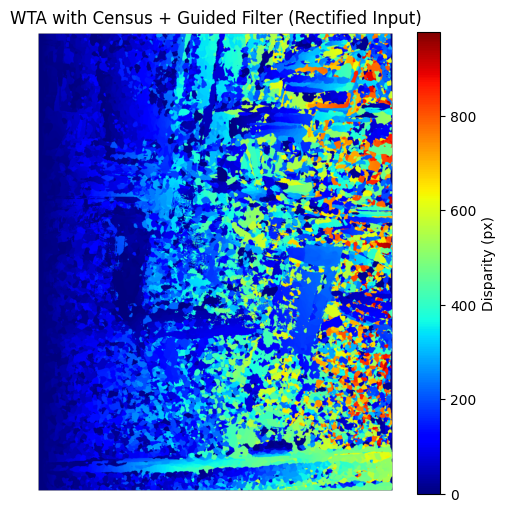

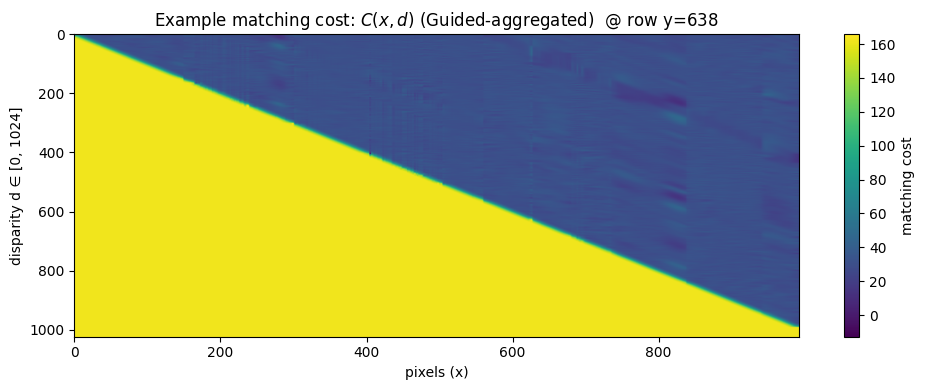

Saved disparity: /content/drive/MyDrive/es-143-assignments-group/Final/0.8_12121108_outputs/disp_census_guided_rectified.png
Saved cost volume figure: /content/drive/MyDrive/es-143-assignments-group/Final/0.8_12121108_outputs/cost_volume_row.png


In [4]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm


left_path  = 'rectified_images_output/two_scene_left_3.png'
right_path = 'rectified_images_output/two_scene_right_3.png'


left  = cv2.imread(left_path,  cv2.IMREAD_GRAYSCALE)
right = cv2.imread(right_path, cv2.IMREAD_GRAYSCALE)
assert left is not None and right is not None, "Failed to load rectified images. Check paths."
H, W = left.shape[:2]
print(f"Loaded rectified pair: shape={left.shape}")


resize_scale = 0.8
if resize_scale != 1.0:
    newW, newH = int(W*resize_scale), int(H*resize_scale)
    left  = cv2.resize(left,  (newW, newH), interpolation=cv2.INTER_AREA)
    right = cv2.resize(right, (newW, newH), interpolation=cv2.INTER_AREA)
    H, W = left.shape[:2]
    print(f"Resized to: {(H, W)}")


def census_transform_uint64(img, win_w=9, win_h=7):
    assert img.ndim == 2
    img = img.astype(np.int16)
    H, W = img.shape
    rh, rw = win_h//2, win_w//2
    sig = np.zeros((H, W), dtype=np.uint64)
    bit = 0
    center = img
    for dy in range(-rh, rh+1):
        for dx in range(-rw, rw+1):
            if dy == 0 and dx == 0:
                continue
            shifted = np.zeros_like(img)
            y0, y1 = max(0,dy), H + min(0,dy)
            x0, x1 = max(0,dx), W + min(0,dx)
            shifted[y0:y1, x0:x1] = img[y0-dy:y1-dy, x0-dx:x1-dx]
            c = (shifted < center).astype(np.uint64)
            sig |= (c << bit)
            bit += 1
            if bit >= 64: break
        if bit >= 64: break
    sig[:rh, :] = 0; sig[-rh:, :] = 0; sig[:, :rw] = 0; sig[:, -rw:] = 0
    return sig

win_w, win_h = 9, 7
left_cen  = census_transform_uint64(left,  win_w=win_w, win_h=win_h)
right_cen = census_transform_uint64(right, win_w=win_w, win_h=win_h)


_POPCNT8 = np.array([bin(i).count("1") for i in range(256)], dtype=np.uint8)
def hamming_uint64(a, b):
    x = np.bitwise_xor(a, b).view(np.uint8).reshape(a.shape + (8,))
    return _POPCNT8[x].sum(axis=-1).astype(np.uint16)


def box_filter(img, r):
    return cv2.boxFilter(img, ddepth=-1, ksize=(2*r+1, 2*r+1), normalize=False, borderType=cv2.BORDER_REFLECT)

def guided_filter(I, p, r=7, eps=1e-2):
    I = I.astype(np.float32); p = p.astype(np.float32)
    ones = np.ones_like(I, dtype=np.float32)
    N = box_filter(ones, r)
    mean_I  = box_filter(I, r) / N
    mean_p  = box_filter(p, r) / N
    mean_Ip = box_filter(I*p, r) / N
    cov_Ip  = mean_Ip - mean_I*mean_p
    mean_II = box_filter(I*I, r) / N
    var_I   = mean_II - mean_I*mean_I
    a = cov_Ip / (var_I + eps)
    b = mean_p - a*mean_I
    mean_a = box_filter(a, r) / N
    mean_b = box_filter(b, r) / N
    return mean_a*I + mean_b


def disparity_census_guided(left_img, right_img, left_cen, right_cen,
                            dmin=0, dmax=64, gf_radius=7, gf_eps=1e-2,
                            viz_row=None):
    H, W = left_img.shape
    guide = (left_img.astype(np.float32) / 255.0)
    best_cost = np.full((H, W), np.inf, dtype=np.float32)
    best_disp = np.full((H, W), np.nan, dtype=np.float32)

    if viz_row is None: viz_row = H // 2
    cost_row_mat = []

    for d in tqdm(range(dmin, dmax+1), desc="Computing disparity", ncols=80):
        shifted = np.zeros_like(right_cen)
        if d < W:
            shifted[:, d:] = right_cen[:, :W-d]

        cost_raw = hamming_uint64(left_cen, shifted).astype(np.float32)
        if d > 0:
            cost_raw[:, :d] = np.max(cost_raw) + 100.0

        cost_agg = guided_filter(guide, cost_raw, r=gf_radius, eps=gf_eps)

        cost_row_mat.append(cost_agg[viz_row, :].copy())


        mask = cost_agg < best_cost
        best_cost[mask] = cost_agg[mask]
        best_disp[mask] = d

    cost_row_mat = np.stack(cost_row_mat, axis=0)
    border = max(3, gf_radius)
    best_disp[:, :border]  = np.nan
    best_disp[:, -border:] = np.nan
    best_disp[:border, :]  = np.nan
    best_disp[-border:, :] = np.nan
    return best_disp, cost_row_mat, viz_row


dmin, dmax = 0, 1024
print(f"Using disparity range: [{dmin}, {dmax}]")


disp_cen_gf, cost_row_mat, row_y = disparity_census_guided(
    left_img=left, right_img=right,
    left_cen=left_cen, right_cen=right_cen,
    dmin=dmin, dmax=dmax,
    gf_radius=7, gf_eps=1e-2,
    viz_row=None
)


plt.figure(figsize=(7,6))
im = plt.imshow(disp_cen_gf, cmap='jet')
plt.title('WTA with Census + Guided Filter (Rectified Input)')
plt.axis('off')
plt.colorbar(im, fraction=0.046, pad=0.04, label='Disparity (px)')
plt.show()


plt.figure(figsize=(10,4))
extent = [0, W, dmax, dmin]
plt.imshow(cost_row_mat, cmap='viridis', aspect='auto', extent=extent)
plt.xlabel("pixels (x)")
plt.ylabel(f"disparity d ∈ [{dmin}, {dmax}]")
plt.title(r"Example matching cost: $C(x,d)$ (Guided-aggregated)  @ row y={}".format(row_y))
cbar = plt.colorbar()
cbar.set_label("matching cost")
plt.tight_layout()
plt.show()


def save_disp_color(disp, out_path, vmin=None, vmax=None):
    d = disp.copy()
    m = np.isnan(d)
    if vmin is None:
        vmin = np.nanpercentile(d, 1) if np.any(~m) else 0.0
    if vmax is None:
        vmax = np.nanpercentile(d, 99) if np.any(~m) else 1.0
    d[m] = vmin
    d = np.clip((d - vmin) / max(1e-6, (vmax - vmin)), 0, 1)
    d_color = cv2.applyColorMap((d * 255).astype(np.uint8), cv2.COLORMAP_JET)
    d_color[m] = (0, 0, 0)
    cv2.imwrite(out_path, d_color)

os.makedirs("0.8_12121108_outputs", exist_ok=True)
out_disp = "0.8_12121108_outputs/disp_census_guided_rectified.png"
save_disp_color(disp_cen_gf, out_disp)
print("Saved disparity:", os.path.abspath(out_disp))

plt.figure(figsize=(10,4))
plt.imshow(cost_row_mat, cmap='viridis', aspect='auto', extent=extent)
plt.xlabel("pixels (x)")
plt.ylabel(f"disparity d ∈ [{dmin}, {dmax}]")
plt.title(r"Example matching cost: $C(x,d)$ (Guided-aggregated)  @ row y={}".format(row_y))
cbar = plt.colorbar(); cbar.set_label("matching cost")
plt.tight_layout()
out_cost = "0.8_12121108_outputs/cost_volume_row.png"
plt.savefig(out_cost, dpi=200, bbox_inches='tight')
plt.close()
print("Saved cost volume figure:", os.path.abspath(out_cost))


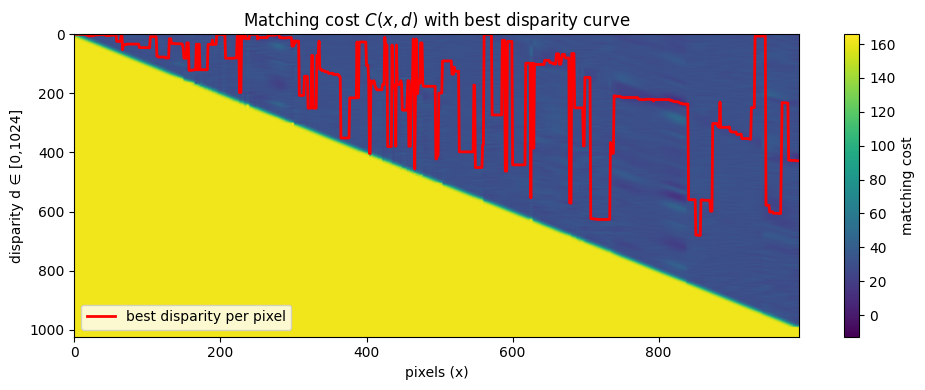

In [5]:
# cost_row_mat: shape (D, W)
d_vals = np.arange(dmin, dmax + 1)
best_d_for_x = d_vals[np.argmin(cost_row_mat, axis=0)]
plt.figure(figsize=(10,4))
extent = [0, W, dmax, dmin]
plt.imshow(cost_row_mat, cmap='viridis', aspect='auto', extent=extent)
plt.plot(np.arange(W), best_d_for_x, 'r-', linewidth=2, label='best disparity per pixel')
plt.xlabel("pixels (x)")
plt.ylabel(f"disparity d ∈ [{dmin},{dmax}]")
plt.title(r"Matching cost $C(x,d)$ with best disparity curve")
plt.legend()
plt.colorbar(label="matching cost")
plt.tight_layout()
plt.show()


##DP

Resized to: (1277, 992)
Using disparity range: [0, 1024]


DP (O(W·D)) scanlines: 100%|██████████| 1277/1277 [01:52<00:00, 11.38row/s]


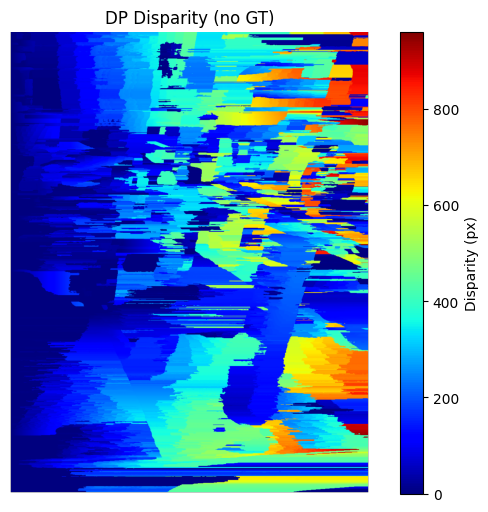

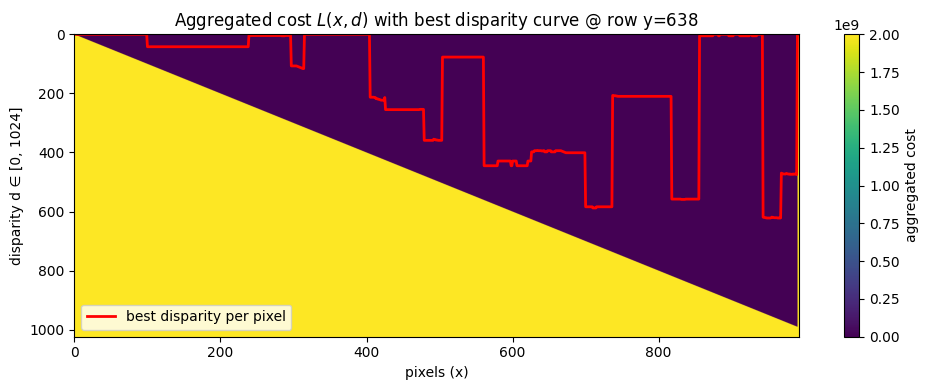

Saved disparity: /content/drive/MyDrive/es-143-assignments-group/Final/0.8_12121108_outputs/disp_dp_noGT.png
Saved cost volume figure: /content/drive/MyDrive/es-143-assignments-group/Final/0.8_12121108_outputs/cost_volume_row_OD.png


In [6]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

# left_path  = 'cones-png-2/cones/im2.png'
# right_path = 'cones-png-2/cones/im6.png'
left_path  = 'rectified_images_output/two_scene_left_3.png'
right_path = 'rectified_images_output/two_scene_right_3.png'

left  = cv2.imread(left_path,  cv2.IMREAD_GRAYSCALE)
right = cv2.imread(right_path, cv2.IMREAD_GRAYSCALE)
assert left is not None and right is not None, "Failed to load images."
resize_scale = 0.8
if resize_scale != 1.0:
    H0, W0 = left.shape
    newW, newH = int(W0 * resize_scale), int(H0 * resize_scale)
    left  = cv2.resize(left,  (newW, newH), interpolation=cv2.INTER_AREA)
    right = cv2.resize(right, (newW, newH), interpolation=cv2.INTER_AREA)
    print(f"Resized to: {left.shape}")

H, W = left.shape


def build_cost_volume_SAD(left, right, dmin, dmax, win=5,
                          normalize=True, show_progress=False):
    H, W = left.shape
    left_f  = left.astype(np.float32)
    right_f = right.astype(np.float32)
    numD = dmax - dmin + 1

    C = np.full((H, W, numD), np.inf, dtype=np.float32)

    disp_iter = range(dmin, dmax + 1)
    if show_progress:
        try:
            from tqdm import tqdm
            disp_iter = tqdm(disp_iter, desc="Building SAD cost", unit="disp")
        except:
            pass

    for k, d in enumerate(disp_iter):
        shifted = np.zeros_like(right_f)
        if d < W:
            shifted[:, d:] = right_f[:, :W - d]

        ad = np.abs(left_f - shifted)

        sad = cv2.boxFilter(ad, ddepth=-1, ksize=(win, win), normalize=False)

        if normalize:
            sad = sad / (win * win * 255.0)

        if d > 0:
            sad[:, :d] = np.inf

        C[:, :, k] = sad

    half = win // 2
    C[:half, :, :] = np.inf
    C[-half:, :, :] = np.inf
    C[:, :half, :] = np.inf
    C[:, -half:, :] = np.inf
    return C

def dp_row_from_costs_OD(cost_row_d, dmin, dmax, P1=0.1, P2=1.0,
                         two_directions=True, return_agg=False):

    W, D = cost_row_d.shape
    INF = 1e9

    L_lr = np.empty((W, D), dtype=np.float32)
    prev = cost_row_d[0].astype(np.float32)
    prev[np.isinf(prev)] = INF
    L_lr[0] = prev

    for x in range(1, W):
        Cx = cost_row_d[x].astype(np.float32)
        Cx[np.isinf(Cx)] = INF
        prev_min = np.min(prev)


        t = np.minimum.reduce(
            np.stack([
                prev,
                np.concatenate(([INF], prev[:-1] + P1)),
                np.concatenate((prev[1:] + P1, [INF])),
                np.full_like(prev, prev_min + P2)
            ], axis=0),
            axis=0
        )

        curr = Cx + t - prev_min
        L_lr[x] = curr
        prev = curr

    if two_directions:
        L_rl = np.empty((W, D), dtype=np.float32)
        prev = cost_row_d[-1].astype(np.float32)
        prev[np.isinf(prev)] = INF
        L_rl[-1] = prev

        for x in range(W - 2, -1, -1):
            Cx = cost_row_d[x].astype(np.float32)
            Cx[np.isinf(Cx)] = INF
            prev_min = np.min(prev)

            t = np.minimum.reduce(
                np.stack([
                    prev,
                    np.concatenate(([INF], prev[:-1] + P1)),
                    np.concatenate((prev[1:] + P1, [INF])),
                    np.full_like(prev, prev_min + P2)
                ], axis=0),
                axis=0
            )

            curr = Cx + t - prev_min
            L_rl[x] = curr
            prev = curr

        L = L_lr + L_rl
    else:
        L = L_lr

    disp_idx = np.argmin(L, axis=1)
    disp_row = disp_idx.astype(np.float32) + float(dmin)

    invalid = ~np.isfinite(np.min(cost_row_d, axis=1))
    disp_row[invalid] = np.nan

    if return_agg:
        return disp_row, L
    else:
        return disp_row


def stereo_dp_OD(C, dmin, dmax, P1=0.1, P2=1.0,
                 two_directions=True, show_progress=False,
                 viz_row=None):

    H, W, D = C.shape
    disp = np.full((H, W), np.nan, dtype=np.float32)

    if viz_row is None:
        viz_row = H // 2
    cost_row_mat = None

    row_iter = range(H)
    if show_progress:
        try:
            from tqdm import tqdm
            row_iter = tqdm(row_iter, desc="DP (O(W·D)) scanlines", unit="row")
        except:
            pass

    for y in row_iter:
        cost_row_d = C[y, :, :]
        if y == viz_row:
            disp_row, L_row = dp_row_from_costs_OD(
                cost_row_d, dmin, dmax,
                P1=P1, P2=P2,
                two_directions=two_directions,
                return_agg=True
            )

            cost_row_mat = L_row.T
        else:
            disp_row = dp_row_from_costs_OD(
                cost_row_d, dmin, dmax,
                P1=P1, P2=P2,
                two_directions=two_directions,
                return_agg=False
            )

        disp[y, :] = disp_row

    return disp, cost_row_mat, viz_row


dmin, dmax = 0, 1024
print(f"Using disparity range: [{dmin}, {dmax}]")

C = build_cost_volume_SAD(
    left, right,
    dmin=dmin, dmax=dmax,
    win=5, normalize=True,
    show_progress=True
)

disp_dp, cost_row_mat, row_y = stereo_dp_OD(
    C, dmin, dmax,
    P1=0.1, P2=1.0,
    two_directions=True,
    show_progress=True,
    viz_row=None
)


plt.figure(figsize=(8, 6))
im = plt.imshow(disp_dp, cmap='jet')
plt.title("DP Disparity (no GT)")
plt.axis('off')
plt.colorbar(im, label='Disparity (px)')
plt.show()


D, Wv = cost_row_mat.shape
assert Wv == W, "Width mismatch for visualization."

d_vals = np.arange(dmin, dmax + 1)
best_d_for_x = d_vals[np.argmin(cost_row_mat, axis=0)]

plt.figure(figsize=(10, 4))
extent = [0, W, dmax, dmin]
plt.imshow(cost_row_mat, cmap='viridis', aspect='auto', extent=extent)
plt.plot(np.arange(W), best_d_for_x, 'r-', linewidth=2, label='best disparity per pixel')
plt.xlabel("pixels (x)")
plt.ylabel(f"disparity d ∈ [{dmin}, {dmax}]")
plt.title(rf"Aggregated cost $L(x,d)$ with best disparity curve @ row y={row_y}")
plt.legend()
cbar = plt.colorbar()
cbar.set_label("aggregated cost")
plt.tight_layout()
plt.show()


def save_disp_color(disp, out_path):
    d = disp.copy()
    m = np.isnan(d)
    if np.any(~m):
        vmin = np.nanpercentile(d, 1)
        vmax = np.nanpercentile(d, 99)
    else:
        vmin, vmax = 0.0, 1.0
    d[m] = vmin
    d = np.clip((d - vmin) / max(1e-6, (vmax - vmin)), 0, 1)
    d_color = cv2.applyColorMap((d * 255).astype(np.uint8), cv2.COLORMAP_JET)
    d_color[m] = (0, 0, 0)
    cv2.imwrite(out_path, d_color)

os.makedirs("0.8_12121108_outputs", exist_ok=True)

out_disp = "0.8_12121108_outputs/disp_dp_noGT.png"
save_disp_color(disp_dp, out_disp)
print("Saved disparity:", os.path.abspath(out_disp))


plt.figure(figsize=(10, 4))
plt.imshow(cost_row_mat, cmap='viridis', aspect='auto', extent=extent)
plt.plot(np.arange(W), best_d_for_x, 'r-', linewidth=2)
plt.xlabel("pixels (x)")
plt.ylabel(f"disparity d ∈ [{dmin}, {dmax}]")
plt.title(rf"Aggregated cost $L(x,d)$ @ row y={row_y}")
cbar = plt.colorbar()
cbar.set_label("aggregated cost")
plt.tight_layout()
out_cost = "0.8_12121108_outputs/cost_volume_row_OD.png"
plt.savefig(out_cost, dpi=200, bbox_inches='tight')
plt.close()
print("Saved cost volume figure:", os.path.abspath(out_cost))


In [7]:
import os
import sys
import cv2
import numpy as np
import torch
import matplotlib.pyplot as plt
import urllib.request
from PIL import Image

# Utility to display results
def visualize_result(img, disp, title="Disparity"):
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.imshow(img)
    plt.title("Left Image")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(disp, cmap='magma')
    plt.title(title)
    plt.colorbar(label='Disparity (px)')
    plt.axis('off')
    plt.show()

Mounted at /content/drive
Working directory: /content/drive/MyDrive/es-143-assignments-group/Final
Running SGBM: Range=[-256, 128], Block=3


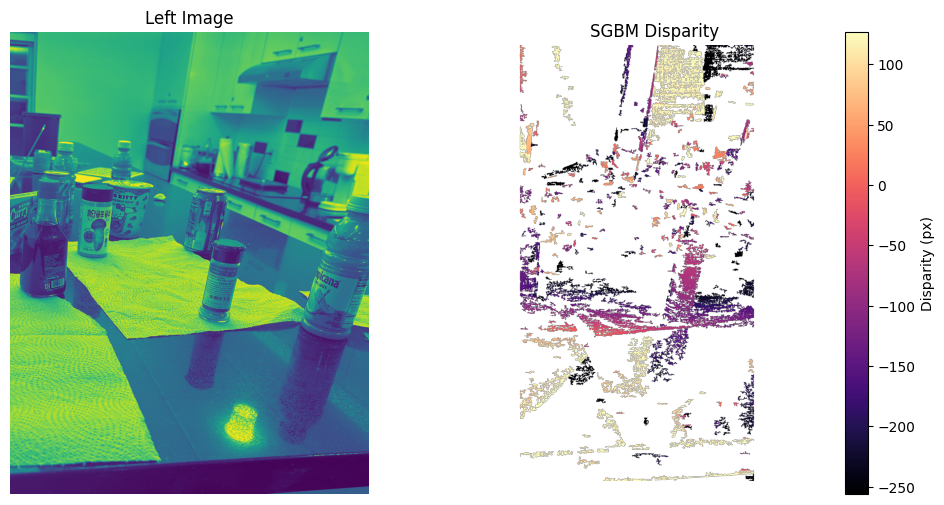

SGBM result saved to outputs/sgbm_result.png
Running SGBM: Range=[-256, 128], Block=3


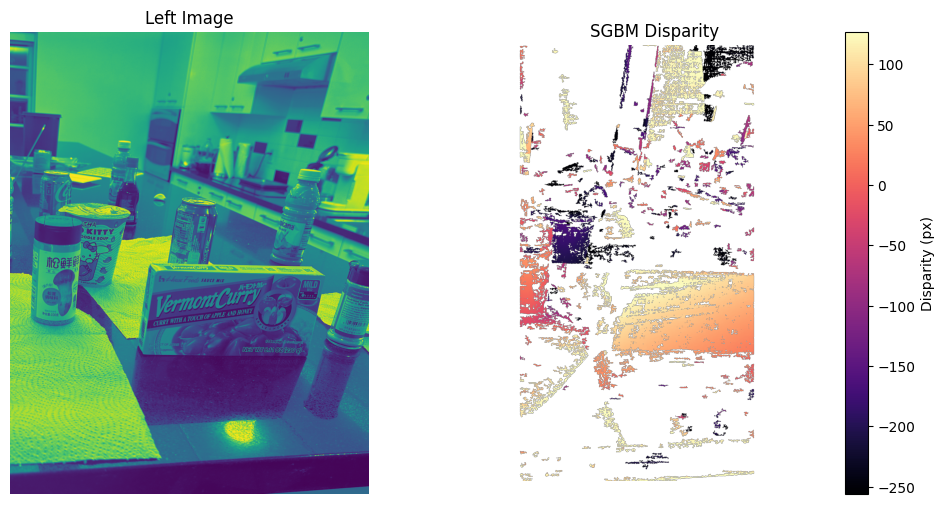

SGBM result saved to outputs/sgbm_result2.png
Running SGBM: Range=[-256, 128], Block=3


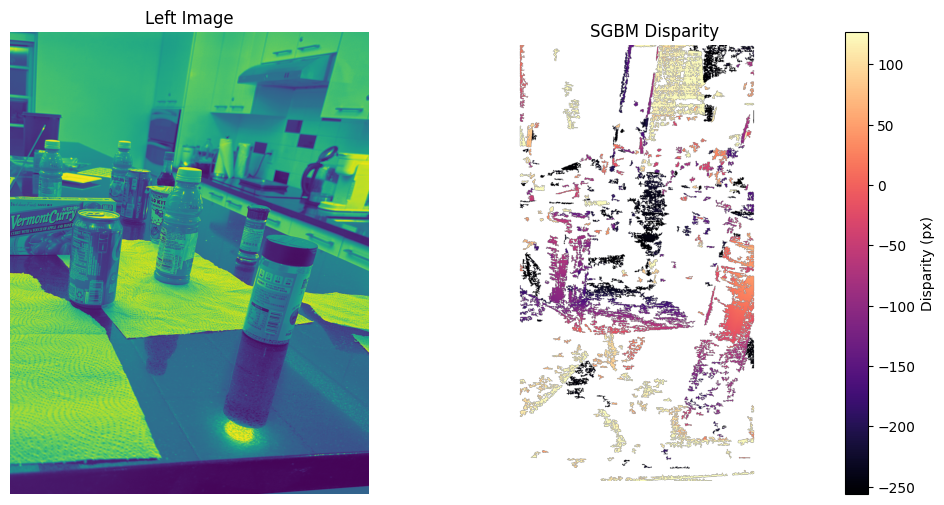

SGBM result saved to outputs/sgbm_result3.png


In [8]:
def disparity_sgbm_opencv(left_rect, right_rect, min_disp=0, num_disparities=64,
                          block_size=5, p1=None, p2=None, uniqueness=10, speckle=100):
    # 1. Safety Check: Dimensions
    if left_rect.shape != right_rect.shape:
        raise ValueError(f"Shape Mismatch: Left {left_rect.shape} vs Right {right_rect.shape}. SGBM requires identical sizes.")

    # 2. Safety Check: Channels (Convert Color to Gray)
    if left_rect.ndim == 3:
        left_rect = cv2.cvtColor(left_rect, cv2.COLOR_BGR2GRAY)
    if right_rect.ndim == 3:
        right_rect = cv2.cvtColor(right_rect, cv2.COLOR_BGR2GRAY)

    # 3. CRITICAL: Safety Check: Data Type (Must be uint8)
    # SGBM fails on float32/float64 inputs.
    if left_rect.dtype != np.uint8:
        # If float 0-1, scale to 0-255
        if left_rect.max() <= 1.0:
            left_rect = (left_rect * 255).astype(np.uint8)
        else:
            left_rect = left_rect.astype(np.uint8)

    if right_rect.dtype != np.uint8:
        if right_rect.max() <= 1.0:
            right_rect = (right_rect * 255).astype(np.uint8)
        else:
            right_rect = right_rect.astype(np.uint8)

    # ... (Rest of your P1/P2 logic remains the same) ...
    if p1 is None:
        p1 = 8 * 1 * block_size * block_size
    if p2 is None:
        p2 = 32 * 1 * block_size * block_size

    stereo = cv2.StereoSGBM_create(
        minDisparity=min_disp,
        numDisparities=num_disparities,
        blockSize=block_size,
        P1=p1,
        P2=p2,
        disp12MaxDiff=1,
        uniquenessRatio=uniqueness,
        speckleWindowSize=speckle,
        speckleRange=32,
        mode=cv2.STEREO_SGBM_MODE_SGBM_3WAY
    )

    print(f"Running SGBM: Range=[{min_disp}, {min_disp+num_disparities}], Block={block_size}")

    # Compute
    disp_raw = stereo.compute(left_rect, right_rect)

    # Convert result to float32 disparity
    disp = disp_raw.astype(np.float32) / 16.0

    # Mask invalid pixels (OpenCV uses (min_disp-1)*16 for invalid)
    # Using a slightly safer check < min_disp
    disp[disp < min_disp] = np.nan

    return disp

# --- Test SGBM ---
# Assuming 'left' and 'right' images are already loaded from previous cells
# If running standalone, load your images here:

from google.colab import drive
drive.mount('/content/drive', force_remount=True)

PROJECT_DIR = "/content/drive/MyDrive/es-143-assignments-group/Final"
os.makedirs(PROJECT_DIR, exist_ok=True)
os.chdir(PROJECT_DIR)
print("Working directory:", os.getcwd())

left = cv2.imread('rectified_images_output/two_scene_left_1.png', cv2.IMREAD_GRAYSCALE)
right = cv2.imread('rectified_images_output/two_scene_right_1.png', cv2.IMREAD_GRAYSCALE)
h_min = min(left.shape[0], right.shape[0])
w_min = min(left.shape[1], right.shape[1])

if left.shape != (h_min, w_min) or right.shape != (h_min, w_min):
    print(f"Warning: Resizing images from {left.shape}/{right.shape} to ({h_min}, {w_min})")
    left = left[:h_min, :w_min]
    right = right[:h_min, :w_min]

if 'left' in globals() and 'right' in globals():
    disp_sgbm = disparity_sgbm_opencv(left, right, min_disp=-256, num_disparities=384, block_size=3)
    visualize_result(left, disp_sgbm, title="SGBM Disparity")

    # Optional: Save for report
    os.makedirs("outputs", exist_ok=True)
    plt.imsave("outputs/sgbm_result1.png", disp_sgbm, cmap='magma')
    print("SGBM result saved to outputs/sgbm_result.png")
else:
    print("Images 'left' and 'right' not found in memory. Please load images first.")


left = cv2.imread('rectified_images_output/two_scene_left_2.png', cv2.IMREAD_GRAYSCALE)
right = cv2.imread('rectified_images_output/two_scene_right_2.png', cv2.IMREAD_GRAYSCALE)
h_min = min(left.shape[0], right.shape[0])
w_min = min(left.shape[1], right.shape[1])

if left.shape != (h_min, w_min) or right.shape != (h_min, w_min):
    print(f" Warning: Resizing images from {left.shape}/{right.shape} to ({h_min}, {w_min})")
    left = left[:h_min, :w_min]
    right = right[:h_min, :w_min]

if 'left' in globals() and 'right' in globals():
    disp_sgbm = disparity_sgbm_opencv(left, right, min_disp=-256, num_disparities=384, block_size=3)
    visualize_result(left, disp_sgbm, title="SGBM Disparity")

    # Optional: Save for report
    os.makedirs("outputs", exist_ok=True)
    plt.imsave("outputs/sgbm_result2.png", disp_sgbm, cmap='magma')
    print("SGBM result saved to outputs/sgbm_result2.png")
else:
    print("Images 'left' and 'right' not found in memory. Please load images first.")

left = cv2.imread('rectified_images_output/two_scene_left_3.png', cv2.IMREAD_GRAYSCALE)
right = cv2.imread('rectified_images_output/two_scene_right_3.png', cv2.IMREAD_GRAYSCALE)
h_min = min(left.shape[0], right.shape[0])
w_min = min(left.shape[1], right.shape[1])

if left.shape != (h_min, w_min) or right.shape != (h_min, w_min):
    print(f"Warning: Resizing images from {left.shape}/{right.shape} to ({h_min}, {w_min})")
    left = left[:h_min, :w_min]
    right = right[:h_min, :w_min]

if 'left' in globals() and 'right' in globals():
    disp_sgbm = disparity_sgbm_opencv(left, right, min_disp=-256, num_disparities=384, block_size=3)
    visualize_result(left, disp_sgbm, title="SGBM Disparity")

    # Optional: Save for report
    os.makedirs("outputs", exist_ok=True)
    plt.imsave("outputs/sgbm_result3.png", disp_sgbm, cmap='magma')
    print("SGBM result saved to outputs/sgbm_result3.png")
else:
    print("Images 'left' and 'right' not found in memory. Please load images first.")


You will first need to download the pth file for raft stereao matching.

https://www.dropbox.com/scl/fi/z720aslw752iypqqdre7c/models.zip?rlkey=3criskutu26wwrx4h9g42aqx0&e=1

Starting Deep Learning Inference...
Running RAFT-Stereo on: cuda


/content/drive/MyDrive/es-143-assignments-group/Final/RAFT-Stereo/core/raft_stereo.py:77: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=self.args.mixed_precision):
/usr/local/lib/python3.12/dist-packages/torch/functional.py:505: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /pytorch/aten/src/ATen/native/TensorShape.cpp:4317.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
/content/drive/MyDrive/es-143-assignments-group/Final/RAFT-Stereo/core/raft_stereo.py:112: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=self.args.mixed_precision):


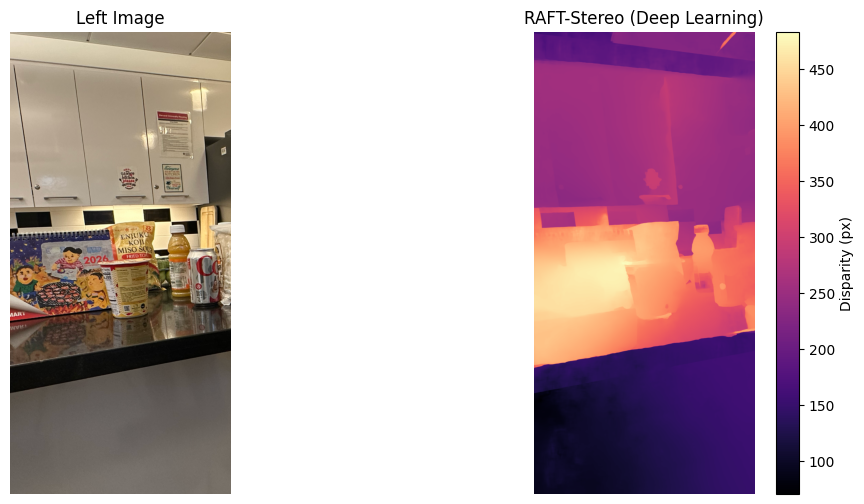

RAFT result saved to outputs/raft_result1.png
Starting Deep Learning Inference...
Running RAFT-Stereo on: cuda


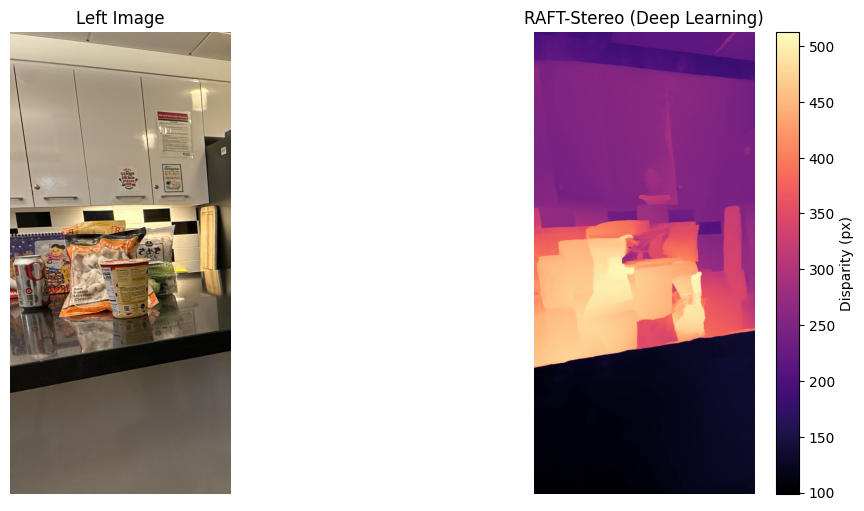

RAFT result saved to outputs/raft_result2.png
Starting Deep Learning Inference...
Running RAFT-Stereo on: cuda


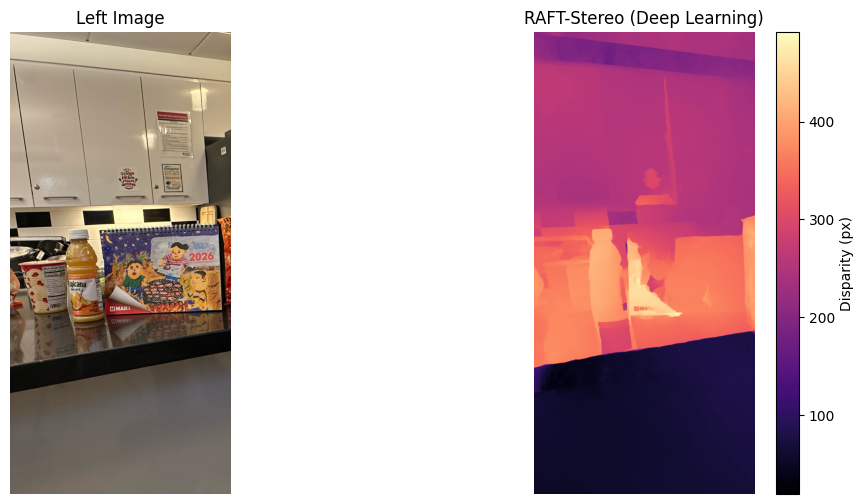

RAFT result saved to outputs/raft_result3.png


In [9]:
def setup_raft_stereo():
    if not os.path.exists("RAFT-Stereo"):
        print("Cloning RAFT-Stereo repository...")
        !git clone https://github.com/princeton-vl/RAFT-Stereo.git

    # Append to path to import modules
    sys.path.append("RAFT-Stereo")

    # Create models directory
    if not os.path.exists("models"):
        os.makedirs("models")



    model_path = "models/raftstereo-middlebury.pth"
    return model_path

def disparity_raft_stereo(left_img_np, right_img_np, model_path, use_cuda=True):
    """
    Runs RAFT-Stereo inference.
    Args:
        left_img_np, right_img_np: Images in BGR or RGB (H, W, 3).
        model_path: Path to .pth file.
    """
    # Import inside function to ensure path is set
    sys.path.append("RAFT-Stereo")
    try:
        from core.raft_stereo import RAFTStereo
        from core.utils.utils import InputPadder
    except ImportError:
        print("Error: Could not import RAFT-Stereo modules. Make sure the repo is cloned.")
        return None

    # Configuration for RAFT-Stereo
    class Args:
        restore_ckpt = model_path
        save_numpy = False
        mixed_precision = True # Use False for stability unless you have amp installed
        valid_iters = 32
        hidden_dims = [128, 128, 128] # Changed to list
        context_dims = [128, 128, 128] # Changed to list
        corr_implementation = "reg" # "reg" or "alt"
        shared_backbone = False
        corr_levels = 4
        corr_radius = 4
        n_downsample = 2
        slow_fast_gru = False
        n_gru_layers = 3
        # Added missing arguments required by RAFTStereo architecture
        context_norm = "batch"
        feature_norm = "instance"

    args = Args()

    device = torch.device('cuda' if torch.cuda.is_available() and use_cuda else 'cpu')
    print(f"Running RAFT-Stereo on: {device}")

    # Load Model
    model = torch.nn.DataParallel(RAFTStereo(args), device_ids=[0])
    model.load_state_dict(torch.load(args.restore_ckpt, map_location=device))
    model = model.module
    model.to(device)
    model.eval()

    # Preprocess Images
    # RAFT expects [1, 3, H, W], normalized roughly to [0, 255] (it handles normalization internally usually,
    # but let's stick to tensor format).
    # Convert numpy (H, W, C) -> Tensor (1, C, H, W)

    if left_img_np.ndim == 2: # Handle grayscale
        left_img_np = cv2.cvtColor(left_img_np, cv2.COLOR_GRAY2RGB)
        right_img_np = cv2.cvtColor(right_img_np, cv2.COLOR_GRAY2RGB)

    imgL = torch.from_numpy(left_img_np).permute(2, 0, 1).float()
    imgR = torch.from_numpy(right_img_np).permute(2, 0, 1).float()

    imgL = imgL[None].to(device)
    imgR = imgR[None].to(device)

    # Padding (RAFT-Stereo requires dimensions divisible by 8)
    padder = InputPadder(imgL.shape)
    imgL, imgR = padder.pad(imgL, imgR)

    # Inference
    with torch.no_grad():
        # valid_iters=32 is standard for high quality
        _, flow_up = model(imgL, imgR, iters=32, test_mode=True)

    # Post-process
    # FIX: Unpad the flow output *before* extracting the numpy array
    # InputPadder.unpad expects a 4D tensor, not a 2D numpy array
    flow_up = padder.unpad(flow_up)

    # flow_up contains (disparity, vertical_flow). We only need disparity (index 0).
    # RAFT outputs disparity as negative flow in X direction usually, let's check magnitude.
    # In RAFT-Stereo code: flow output is 2 channels. Channel 0 is disparity (positive).
    disp = flow_up[0, 0].cpu().numpy() # Extract disparity channel

    return -1 * disp # RAFT-Stereo output is strictly -disparity (flow from left to right)

# --- Run the Neural Network Task ---

# 1. Setup
model_weights = setup_raft_stereo()

left_path  = 'rectified_images_output/mirror_scene_left_half_1.png'
right_path = 'rectified_images_output/mirror_scene_right_half_1.png'

imgL_color = cv2.imread(left_path, cv2.IMREAD_COLOR)
imgR_color = cv2.imread(right_path, cv2.IMREAD_COLOR)
imgL_color = cv2.cvtColor(imgL_color, cv2.COLOR_BGR2RGB)
imgR_color = cv2.cvtColor(imgR_color, cv2.COLOR_BGR2RGB)

h_min = min(imgL_color.shape[0], imgR_color.shape[0])
w_min = min(imgL_color.shape[1], imgR_color.shape[1])

if imgL_color.shape != (h_min, w_min) or imgR_color.shape != (h_min, w_min):
    imgL_color = imgL_color[:h_min, :w_min]
    imgR_color = imgR_color[:h_min, :w_min]


# 3. Compute
if os.path.exists(model_weights) and imgL_color is not None:
    print("Starting Deep Learning Inference...")
    disp_raft = disparity_raft_stereo(imgL_color, imgR_color, model_weights)

    # RAFT output is negative flow (pixels move left), so we flip sign for visualization
    # However, depending on version, check values. If negative, multiply by -1.
    if np.mean(disp_raft) < 0:
        disp_raft = -disp_raft

    visualize_result(imgL_color, disp_raft, title="RAFT-Stereo (Deep Learning)")

    # Save
    plt.imsave("outputs/raft_result1.png", disp_raft, cmap='magma')
    print("RAFT result saved to outputs/raft_result1.png")
else:
    print("Skipping RAFT execution: Model weights or images missing.")



left_path  = 'rectified_images_output/mirror_scene_left_half_2.png'
right_path = 'rectified_images_output/mirror_scene_right_half_2.png'

imgL_color = cv2.imread(left_path, cv2.IMREAD_COLOR)
imgR_color = cv2.imread(right_path, cv2.IMREAD_COLOR)
imgL_color = cv2.cvtColor(imgL_color, cv2.COLOR_BGR2RGB)
imgR_color = cv2.cvtColor(imgR_color, cv2.COLOR_BGR2RGB)

h_min = min(imgL_color.shape[0], imgR_color.shape[0])
w_min = min(imgL_color.shape[1], imgR_color.shape[1])

if imgL_color.shape != (h_min, w_min) or imgR_color.shape != (h_min, w_min):
    imgL_color = imgL_color[:h_min, :w_min]
    imgR_color = imgR_color[:h_min, :w_min]


# 3. Compute
if os.path.exists(model_weights) and imgL_color is not None:
    print("Starting Deep Learning Inference...")
    disp_raft = disparity_raft_stereo(imgL_color, imgR_color, model_weights)

    # RAFT output is negative flow (pixels move left), so we flip sign for visualization
    # However, depending on version, check values. If negative, multiply by -1.
    if np.mean(disp_raft) < 0:
        disp_raft = -disp_raft

    visualize_result(imgL_color, disp_raft, title="RAFT-Stereo (Deep Learning)")

    # Save
    plt.imsave("outputs/raft_result2.png", disp_raft, cmap='magma')
    print("RAFT result saved to outputs/raft_result2.png")
else:
    print("Skipping RAFT execution: Model weights or images missing.")


left_path  = 'rectified_images_output/mirror_scene_left_half_3.png'
right_path = 'rectified_images_output/mirror_scene_right_half_3.png'

imgL_color = cv2.imread(left_path, cv2.IMREAD_COLOR)
imgR_color = cv2.imread(right_path, cv2.IMREAD_COLOR)
imgL_color = cv2.cvtColor(imgL_color, cv2.COLOR_BGR2RGB)
imgR_color = cv2.cvtColor(imgR_color, cv2.COLOR_BGR2RGB)

h_min = min(imgL_color.shape[0], imgR_color.shape[0])
w_min = min(imgL_color.shape[1], imgR_color.shape[1])

if imgL_color.shape != (h_min, w_min) or imgR_color.shape != (h_min, w_min):
    imgL_color = imgL_color[:h_min, :w_min]
    imgR_color = imgR_color[:h_min, :w_min]


# 3. Compute
if os.path.exists(model_weights) and imgL_color is not None:
    print("Starting Deep Learning Inference...")
    disp_raft = disparity_raft_stereo(imgL_color, imgR_color, model_weights)

    # RAFT output is negative flow (pixels move left), so we flip sign for visualization
    # However, depending on version, check values. If negative, multiply by -1.
    if np.mean(disp_raft) < 0:
        disp_raft = -disp_raft

    visualize_result(imgL_color, disp_raft, title="RAFT-Stereo (Deep Learning)")

    # Save
    plt.imsave("outputs/raft_result3.png", disp_raft, cmap='magma')
    print("RAFT result saved to outputs/raft_result3.png")
else:
    print("Skipping RAFT execution: Model weights or images missing.")

